In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import numpy as np
import pandas as pd
import os
import sys
import json
import pickle
import mplcursors
sns.reset_orig()
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from models import get_models

# Set the output directories here
outdir_10 = 'outdir_10_percent_threshold'
outdir_aic = 'outdir_aic'

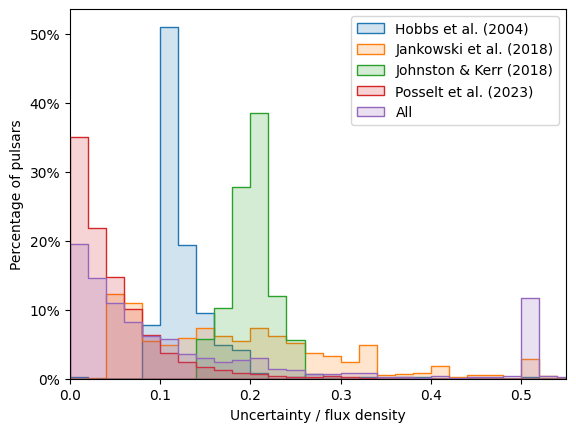

In [2]:
with open(f'../catalogue/catalogue.pkl', 'rb') as f:
    catalogue = pickle.load(f)
    
fig, ax = plt.subplots()

def uncertainty_distribution(ref_name: str, caption: str = None, ax=ax, binwidth=0.02, binrange=(0, 0.55)):
    selected_Ys = []
    selected_YERRs = []
    for jname in catalogue.cat_dict.keys():
        if ref_name == 'All':
            selected_Ys.extend(catalogue.cat_dict[jname]['Y'])
            selected_YERRs.extend(catalogue.cat_dict[jname]['YERR'])
        else:
            if ref_name in catalogue.cat_dict[jname]['REF']:
                for i, ref in enumerate(catalogue.cat_dict[jname]['REF']):
                    if ref == ref_name:
                        selected_Ys.append(catalogue.cat_dict[jname]['Y'][i])
                        selected_YERRs.append(catalogue.cat_dict[jname]['YERR'][i])
    
    selected_Ys = np.array(selected_Ys)
    selected_YERRs = np.array(selected_YERRs)
    YERR_Y = selected_YERRs / selected_Ys
    
    if caption is None and ref_name in catalogue.citation_dict:
        caption = catalogue.citation_dict[ref_name]
    else:
        caption = ref_name
        
    sns.histplot(YERR_Y, binwidth=binwidth, binrange=binrange,
                 kde=False, label=caption, ax=ax, 
                 stat='probability', element='step', alpha=0.2)
    
uncertainty_distribution('Hobbs_2004a', ax=ax)
uncertainty_distribution('Jankowski_2018', ax=ax)
uncertainty_distribution('Johnston_2018', ax=ax)
uncertainty_distribution('Posselt_2023', ax=ax)
uncertainty_distribution('All', ax=ax)
ax.set_xlim(0, 0.55)
ax.set_xlabel('Uncertainty / flux density')
ax.set_ylabel('Percentage of pulsars')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
ax.legend()
plt.savefig('Uncertainty distribution.pdf', bbox_inches='tight')
plt.show()

Number of pulsars: 872
Number of pulsars with simple power law as the best fitting model: 38
Number of pulsars with simple power law as the best fitting model (AIC): 226


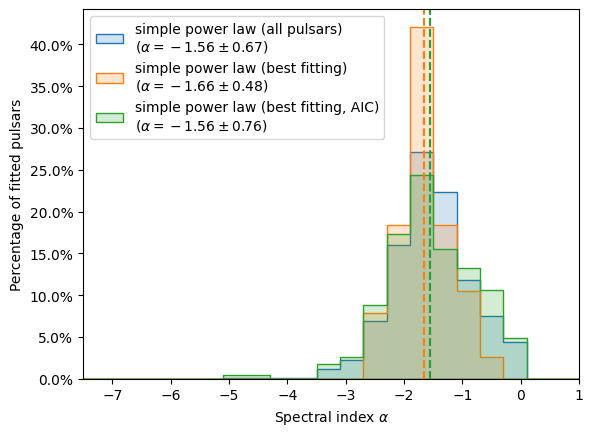

Number of pulsars with simple power law as the best fitting model: 38
Number of pulsars with low-frequency turn-over power law as the best fitting model: 84
Number of pulsars with high-frequency cut-off power law as the best fitting model: 21


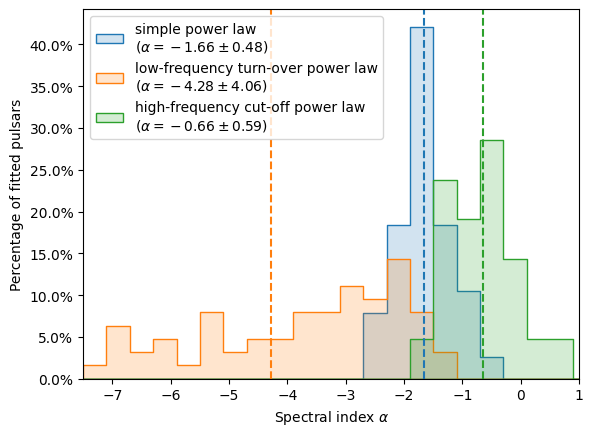

In [3]:
def load_results(outdir: str, var: str):
    with open(f'../output/results_{var}_from_{outdir}.json', 'r', encoding='utf-8-sig') as f:
        results = pd.DataFrame(json.load(f)).T
        results['best_fitting'] = results.iloc[:, :].idxmax(axis=1) if var == 'log_evidence' else results.iloc[:, :].idxmin(axis=1)
    return results
results_10 = load_results(outdir_10, 'log_evidence')
results_aic = load_results(outdir_aic, 'aic')

with open(f'../output/results_param_estimates_from_{outdir_10}.json', 'r', encoding='utf-8-sig') as f:
    param_est_10 = json.load(f)
    
spl_alpha_all, spl_alpha_best, spl_alpha_best_aic = [], [], []
for jname in results_10.index:
    if jname in param_est_10 and 'simple_power_law' in param_est_10[jname]:
        alpha = param_est_10[jname]['simple_power_law']['median'][0]
        spl_alpha_all.append(alpha)
        if results_10.loc[jname, 'best_fitting'] == 'simple_power_law':
            spl_alpha_best.append(alpha)
        if jname in results_aic.index and results_aic.loc[jname, 'best_fitting'] == 'simple_power_law':
            spl_alpha_best_aic.append(alpha)
            
lftopl_alpha_best, hfcopl_alpha_best = [], []
for jname in results_10.index:
    if jname in param_est_10 and 'low_frequency_turn_over_power_law' in param_est_10[jname] and results_10.loc[jname, 'best_fitting'] == 'low_frequency_turn_over_power_law':
        alpha = param_est_10[jname]['low_frequency_turn_over_power_law']['median'][1]
        lftopl_alpha_best.append(alpha)
    if jname in param_est_10 and 'high_frequency_cut_off_power_law' in param_est_10[jname] and results_10.loc[jname, 'best_fitting'] == 'high_frequency_cut_off_power_law':
        alpha = param_est_10[jname]['high_frequency_cut_off_power_law']['median'][1]
        hfcopl_alpha_best.append(alpha)
        
print(f'Number of pulsars: {len(spl_alpha_all)}')
print(f'Number of pulsars with simple power law as the best fitting model: {len(spl_alpha_best)}')
print(f'Number of pulsars with simple power law as the best fitting model (AIC): {len(spl_alpha_best_aic)}')
        
fig, ax = plt.subplots()

sns.histplot(spl_alpha_all, binwidth=0.4, binrange=(-7.5, 1.), kde=False, label=f'simple power law (all pulsars)\n($α = {np.median(spl_alpha_all):.2f} \pm {np.std(spl_alpha_all):.2f}$)', ax=ax, stat='probability', element='step', alpha=0.2)
sns.histplot(spl_alpha_best, binwidth=0.4, binrange=(-7.5, 1.), kde=False, label=f'simple power law (best fitting)\n($α = {np.median(spl_alpha_best):.2f} \pm {np.std(spl_alpha_best):.2f}$)', ax=ax, stat='probability', element='step', alpha=0.2)
sns.histplot(spl_alpha_best_aic, binwidth=0.4, binrange=(-7.5, 1.), kde=False, label=f'simple power law (best fitting, AIC)\n($α = {np.median(spl_alpha_best_aic):.2f} \pm {np.std(spl_alpha_best_aic):.2f}$)', ax=ax, stat='probability', element='step', alpha=0.2)
ylim = ax.get_ylim()
ax.vlines(np.median(spl_alpha_all), *ylim, color='C0', linestyle='--')
ax.vlines(np.median(spl_alpha_best), *ylim, color='C1', linestyle='--')
ax.vlines(np.median(spl_alpha_best_aic), *ylim, color='C2', linestyle='--')
ax.set_ylim(ylim)
ax.set_xlabel('Spectral index $α$')
ax.set_ylabel('Percentage of fitted pulsars')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
ax.set_xlim(-7.5, 1.)
ax.legend(loc='upper left')
plt.savefig('Spectral index distribution (simple power law).pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()

print(f'Number of pulsars with simple power law as the best fitting model: {len(spl_alpha_best)}')
print(f'Number of pulsars with low-frequency turn-over power law as the best fitting model: {len(lftopl_alpha_best)}')
print(f'Number of pulsars with high-frequency cut-off power law as the best fitting model: {len(hfcopl_alpha_best)}')

sns.histplot(spl_alpha_best, binwidth=0.4, binrange=(-7.5, 1.), kde=False, label=f'simple power law\n($α = {np.median(spl_alpha_best):.2f} \pm {np.std(spl_alpha_best):.2f}$)', ax=ax, stat='probability', element='step', alpha=0.2)
sns.histplot(lftopl_alpha_best, binwidth=0.4, binrange=(-7.5, 1.), kde=False, label=f'low-frequency turn-over power law\n($α = {np.median(lftopl_alpha_best):.2f} \pm {np.std(lftopl_alpha_best):.2f}$)', ax=ax, stat='probability', element='step', alpha=0.2)
sns.histplot(hfcopl_alpha_best, binwidth=0.4, binrange=(-7.5, 1.), kde=False, label=f'high-frequency cut-off power law\n($α = {np.median(hfcopl_alpha_best):.2f} \pm {np.std(hfcopl_alpha_best):.2f}$)', ax=ax, stat='probability', element='step', alpha=0.2)

ylim = ax.get_ylim()
ax.vlines(np.median(spl_alpha_best), *ylim, color='C0', linestyle='--')
ax.vlines(np.median(lftopl_alpha_best), *ylim, color='C1', linestyle='--')
ax.vlines(np.median(hfcopl_alpha_best), *ylim, color='C2', linestyle='--')
ax.set_ylim(ylim)
ax.set_xlabel('Spectral index $α$')
ax.set_ylabel('Percentage of fitted pulsars')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
ax.set_xlim(-7.5, 1.)
ax.legend(loc='upper left')
plt.savefig('Spectral index distribution (comparison).pdf', bbox_inches='tight')
plt.show()

Number of pulsars with low-frequency turn-over power law as the best fitting model: 84


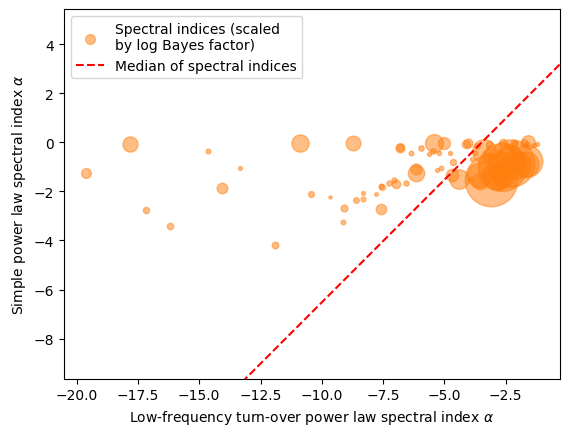

Number of pulsars with high-frequency cut-off power law as the best fitting model: 21


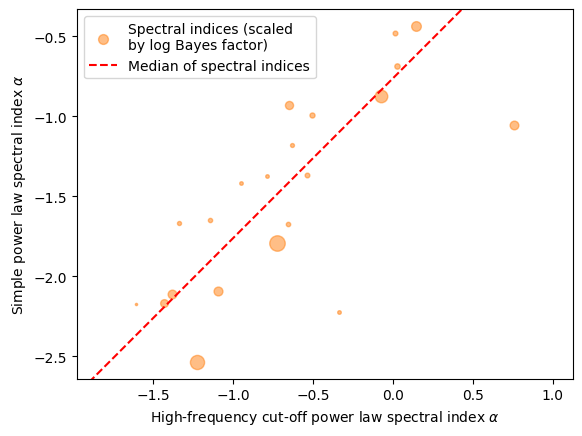

In [4]:
def plot_aa_scatter(x, y, xlabel, ylabel, labels=None, xlim = None, ylim = None, title = '', bf: list = None, legend_loc='best'):
    fig, ax = plt.subplots()
    
    if bf is None:
        plt.scatter(x, y, s=5)
    else:
        scatters = []
        for i in range(len(x)):
            scatter = plt.scatter(x[i], y[i], s=bf[i] * 2, color='tab:orange', alpha=0.5)
            scatters.append(scatter)
        if labels is not None:
            cursor = mplcursors.cursor(scatters, hover=True)
            cursor.connect('add', lambda sel: sel.annotation.set_text(labels[np.where(np.array(scatters) == sel.artist)[0][0]]))
            
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()
        
    # draw a hidden point to show the scatter plot in the legend
    plt.scatter([], [], s=50, alpha=0.5, color='tab:orange', label='Spectral indices (scaled\nby log Bayes factor)')
    
    x_median = np.median(x)
    y_median = np.median(y)
    intercept = y_median - x_median
    plt.plot([-20, 20], [-20 + intercept, 20 + intercept], 'r--', label='Median of spectral indices')
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(xlim)
    plt.ylim(ylim)
    ax.set_aspect('equal', adjustable='datalim')
    plt.legend(loc=legend_loc)
    plt.savefig(f'{title}.pdf', bbox_inches='tight')
    plt.show()
    
def aa_scatter(model_name: str, model_name_cap: str, interactive=False):
    x = []
    y = []
    bf = []
    labels = []
    extreme_outliers = []
    for jname in results_10.index:
        if 'simple_power_law' in results_10.columns and model_name in results_10.columns and jname in param_est_10 and 'simple_power_law' in param_est_10[jname] and model_name in param_est_10[jname] and results_10.loc[jname, 'best_fitting'] == model_name:
            x.append(param_est_10[jname][model_name]['median'][1])
            y.append(param_est_10[jname]['simple_power_law']['median'][0])
            bf.append(results_10.loc[jname, model_name] - results_10.loc[jname, 'simple_power_law'])
            labels.append(f'{jname}\n$\\alpha_{{\mathrm{{spl}}}} = {x[-1]:.2f}$\n$\\alpha = {y[-1]:.2f}$\n$\\ln \mathrm{{BF}} = {bf[-1]:.2f}$')
            # extreme outliers are points with 
    
    print(f'Number of pulsars with {model_name_cap} as the best fitting model: {len(x)}')
    
    plot_aa_scatter(x, y, 
                    xlabel=f'{model_name_cap.capitalize()} spectral index $α$',
                    ylabel='Simple power law spectral index $α$',
                    labels=labels if interactive else None,
                    title=f'Spectral index comparison (simple power law vs {model_name_cap})',
                    bf=bf, legend_loc='best')
    
INTERACTIVE = False
if INTERACTIVE:
    %matplotlib notebook
aa_scatter('low_frequency_turn_over_power_law', 'low-frequency turn-over power law', interactive=INTERACTIVE)
aa_scatter('high_frequency_cut_off_power_law', 'high-frequency cut-off power law', interactive=INTERACTIVE)